In [1]:
# !pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
import numpy as np
import pyspark.sql.functions as F
import pandas as pd

In [ ]:
# Run this cell if running locally

# spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
# Run this cell for SDSC at 60 gb per node, 30 cores. 

# spark = SparkSession.builder\
#     .config("spark.driver.memory", "4g")\
#     .config("spark.executor.memory", "4g")\
#     .config("spark.executor.instances", 14)\
#     .getOrCreate()

In [ ]:
# Run this cell for SDSC at 80 gb per node, 30 cores. 

spark = SparkSession.builder\
    .config("spark.driver.memory", "8g")\
    .config("spark.executor.memory", "4g")\
    .config("spark.executor.instances", 18)\
    .getOrCreate()

In [5]:
spark

In [6]:
# Load CSV into Spark DataFrame

# Cluster Directory: "/home/kphan/kphan/data/all_reviews/all_reviews.csv"
# dir = "/home/kphan/kphan/data/all_reviews/all_reviews.csv"

dir = "resources/data/all_reviews_100000_sample.csv"
df = spark.read.csv(dir, header=True, inferSchema=True)

# Show df
df.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|                               review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+-----------------+---------------

In [7]:
# List out the columns for ease of view
print(f"Columns in Original Dataframe:\n\n{df.columns}\n")

df.describe().show()


Columns in Original Dataframe:

['recommendationid', 'appid', 'game', 'author_steamid', 'author_num_games_owned', 'author_num_reviews', 'author_playtime_forever', 'author_playtime_last_two_weeks', 'author_playtime_at_review', 'author_last_played', 'language', 'review', 'timestamp_created', 'timestamp_updated', 'voted_up', 'votes_up', 'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase', 'received_for_free', 'written_during_early_access', 'hidden_in_steam_china', 'steam_china_location']

+-------+---------------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+-----------------------+------------------------------+-------------------------+--------------------+------------------+--------------------+--------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+-------------------------------------+--------------------

In [8]:
# Example of problematic row
df.filter(df.recommendationid == 144385593).show()

+----------------+-------+--------------------+--------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+----------+-----------------+--------------------+----------+----------+-----------+-------------------+-------------+-----------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|      author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|    review|timestamp_created|   timestamp_updated|  voted_up|  votes_up|votes_funny|weighted_vote_score|comment_count|   steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+--------------------+----------------------+------------------+

## Initial Data Cleanup / Feature Engineering

In [9]:
# Show data types

df.printSchema()

root
 |-- recommendationid: string (nullable = true)
 |-- appid: string (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: string (nullable = true)
 |-- author_num_games_owned: string (nullable = true)
 |-- author_num_reviews: long (nullable = true)
 |-- author_playtime_forever: double (nullable = true)
 |-- author_playtime_last_two_weeks: double (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: string (nullable = true)
 |-- timestamp_updated: string (nullable = true)
 |-- voted_up: string (nullable = true)
 |-- votes_up: string (nullable = true)
 |-- votes_funny: string (nullable = true)
 |-- weighted_vote_score: string (nullable = true)
 |-- comment_count: string (nullable = true)
 |-- steam_purchase: string (nullable = true)
 |-- received_for_free: string (nullable = true)
 |-- writt

In [10]:
# Drop multiple columns not being used for study

# Dropping review column as content will not be evaluated (not exploring NLP in this case)
df_cleaned = df.drop("steam_china_location", "hidden_in_steam_china", "review")

# Show the updated DataFrame
df_cleaned.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played| language|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|
+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+---------+-----------------+-------

In [11]:
# Only use reviews in which the weighted vote score is greater than zero

# Convert column to float
df_cleaned = df.withColumn("weighted_vote_score", F.col("weighted_vote_score").cast("float"))

# Then filter
df_cleaned = df_cleaned.filter(F.col("weighted_vote_score") > 0)
df_cleaned.select("weighted_vote_score").summary().show()
df_cleaned.show(10)

+-------+--------------------+
|summary| weighted_vote_score|
+-------+--------------------+
|  count|               33957|
|   mean| 1.687909492065072E7|
| stddev|1.6219535008042526E8|
|    min|        0.0035619116|
|    25%|          0.48668483|
|    50%|           0.5217391|
|    75%|          0.53038675|
|    max|        1.69888474E9|
+-------+--------------------+

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author

In [12]:
# Convert necessary columns to correct type

columns_to_int = ["recommendationid", "appid", "author_num_games_owned", "author_num_reviews", "author_playtime_forever", "author_playtime_last_two_weeks", "voted_up", "votes_up", "votes_funny", "comment_count", "steam_purchase", "received_for_free", "written_during_early_access"]
for column in columns_to_int: 
    df_cleaned = df_cleaned.withColumn(column, F.col(column).cast("int"))

columns_to_long = ["author_steamid", "timestamp_created", "timestamp_updated"]
for column in columns_to_long: 
    df_cleaned = df_cleaned.withColumn(column, F.col(column).cast("long"))


In [13]:
# Confirm changed schema
df_cleaned.printSchema()
df_cleaned.count()

root
 |-- recommendationid: integer (nullable = true)
 |-- appid: integer (nullable = true)
 |-- game: string (nullable = true)
 |-- author_steamid: long (nullable = true)
 |-- author_num_games_owned: integer (nullable = true)
 |-- author_num_reviews: integer (nullable = true)
 |-- author_playtime_forever: integer (nullable = true)
 |-- author_playtime_last_two_weeks: integer (nullable = true)
 |-- author_playtime_at_review: integer (nullable = true)
 |-- author_last_played: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- review: string (nullable = true)
 |-- timestamp_created: long (nullable = true)
 |-- timestamp_updated: long (nullable = true)
 |-- voted_up: integer (nullable = true)
 |-- votes_up: integer (nullable = true)
 |-- votes_funny: integer (nullable = true)
 |-- weighted_vote_score: float (nullable = true)
 |-- comment_count: integer (nullable = true)
 |-- steam_purchase: integer (nullable = true)
 |-- received_for_free: integer (nullable = true)
 |-

33957

In [14]:
# Remove rows caused by incorrect data type
df_cleaned = df_cleaned.dropna(subset = ["recommendationid", "appid", "author_steamid", "timestamp_created", "timestamp_updated"])
df_cleaned.count()

33160

In [ ]:
# df_cleaned.summary().show()

+-------+-------------------+-----------------+--------------------------+--------------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+--------------------+----------+--------------------+--------------------+--------------------+-------------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+---------------------------+---------------------+--------------------+
|summary|   recommendationid|            appid|                      game|      author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|  author_last_played|  language|              review|   timestamp_created|   timestamp_updated|           voted_up|          votes_up|       votes_funny|weighted_vote_score|      comment_count|     steam_purchase|  received_for_free|written_during_early_acces

In [16]:
# Converting author playtime to hours
df_cleaned = (
    df_cleaned
    .withColumn("author_playtime_forever", F.col("author_playtime_forever").cast("float") / 60)
    .withColumn("author_playtime_at_review", F.col("author_playtime_at_review").cast("float") / 60)
)

df_cleaned.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|                               review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+-----------------+-----------------

In [17]:
### Not necessary just thought it would make playtime cleaner ###

# Round playtime to whole number

df_cleaned = (
    df_cleaned
    .withColumn("author_playtime_forever", F.round(F.col("author_playtime_forever"), 0))
    .withColumn("author_playtime_at_review", F.round(F.col("author_playtime_at_review"), 0))
)

df_cleaned.show(10)

+----------------+-------+--------------------+-----------------+----------------------+------------------+-----------------------+------------------------------+-------------------------+------------------+--------+-------------------------------------+-----------------+-----------------+--------+--------+-----------+-------------------+-------------+--------------+-----------------+---------------------------+---------------------+--------------------+
|recommendationid|  appid|                game|   author_steamid|author_num_games_owned|author_num_reviews|author_playtime_forever|author_playtime_last_two_weeks|author_playtime_at_review|author_last_played|language|                               review|timestamp_created|timestamp_updated|voted_up|votes_up|votes_funny|weighted_vote_score|comment_count|steam_purchase|received_for_free|written_during_early_access|hidden_in_steam_china|steam_china_location|
+----------------+-------+--------------------+-----------------+-----------------

In [18]:
# Removing any duplicates (and counting) - long/expensive operation

before = df_cleaned.count()
df_cleaned = df_cleaned.dropDuplicates()
after =df_cleaned.count()

print(f"Count of rows before: {before}\nCount of rows after: {after}")

Count of rows before: 33160
Count of rows after: 33160


In [ ]:
# Save cleaned dataframe
df_cleaned.coalesce(1).write.csv("/home/kphan/kphan/data", header=True)

## Visualizations for Playtime

Moved to separate notebook

In [ ]:
# # Bar graph which games have the most play time (of reviews)

# # Looking to represent playtime statistics for each game

# total_playtimes = (
#     df_cleaned.groupBy("game")
#     .agg(F.sum("author_playtime_at_review").alias("Total Reviewer Playtime (At time of review)"), F.count("*").alias("Review Count"))
#     .withColumn("Average Playtime Per Review", F.round(F.col("Total Reviewer Playtime (At time of review)") / F.col("Review Count")))
# )

# total_playtimes.show()

+--------------------+-------------------------------------------+------------+---------------------------+
|                game|Total Reviewer Playtime (At time of review)|Review Count|Average Playtime Per Review|
+--------------------+-------------------------------------------+------------+---------------------------+
|Company of Heroes...|                                       15.0|           4|                        4.0|
|The Elder Scrolls...|                                    16350.0|          89|                      184.0|
|                Maze|                                        0.0|           1|                        0.0|
|          Planet Zoo|                                     2067.0|          23|                       90.0|
|                RIFT|                                        3.0|           2|                        2.0|
|Business Tour - O...|                                      223.0|          17|                       13.0|
|DRAGON BALL FighterZ|      

In [ ]:
# # Conversion of aggregated table to Pandas for visualization
# top_10_reviewer_playtimes_df = total_playtimes.orderBy(F.col("Total Reviewer Playtime (At time of review)").desc()).limit(10).toPandas()
# top_10_review_count_df = total_playtimes.orderBy(F.col("Review Count").desc()).limit(10).toPandas()

In [ ]:
# top_10_reviewer_playtimes_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1131681.0,2190,517.0
1,Rust,145698.0,300,486.0
2,Team Fortress 2,139770.0,278,503.0
3,PUBG: BATTLEGROUNDS,133506.0,503,265.0
4,Garry's Mod,110618.0,238,465.0
5,Tom Clancy's Rainbow Six Siege,93441.0,321,291.0
6,Dead by Daylight,79263.0,217,365.0
7,Warframe,76560.0,134,571.0
8,ARK: Survival Evolved,68946.0,199,346.0
9,Grand Theft Auto V,68546.0,375,183.0


In [ ]:
# top_10_review_count_df

,game,Total Reviewer Playtime (At time of review),Review Count,Average Playtime Per Review
0,Counter-Strike 2,1131681.0,2190,517.0
1,PUBG: BATTLEGROUNDS,133506.0,503,265.0
2,Grand Theft Auto V,68546.0,375,183.0
3,Tom Clancy's Rainbow Six Siege,93441.0,321,291.0
4,Rust,145698.0,300,486.0
5,Team Fortress 2,139770.0,278,503.0
6,Terraria,38856.0,266,146.0
7,Garry's Mod,110618.0,238,465.0
8,PAYDAY 2,25818.0,224,115.0
9,Dead by Daylight,79263.0,217,365.0


C:\Users\Khanh Phan\AppData\Local\Temp\ipykernel_46384\2796111726.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\Khanh Phan\AppData\Local\Temp\ipykernel_46384\2796111726.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


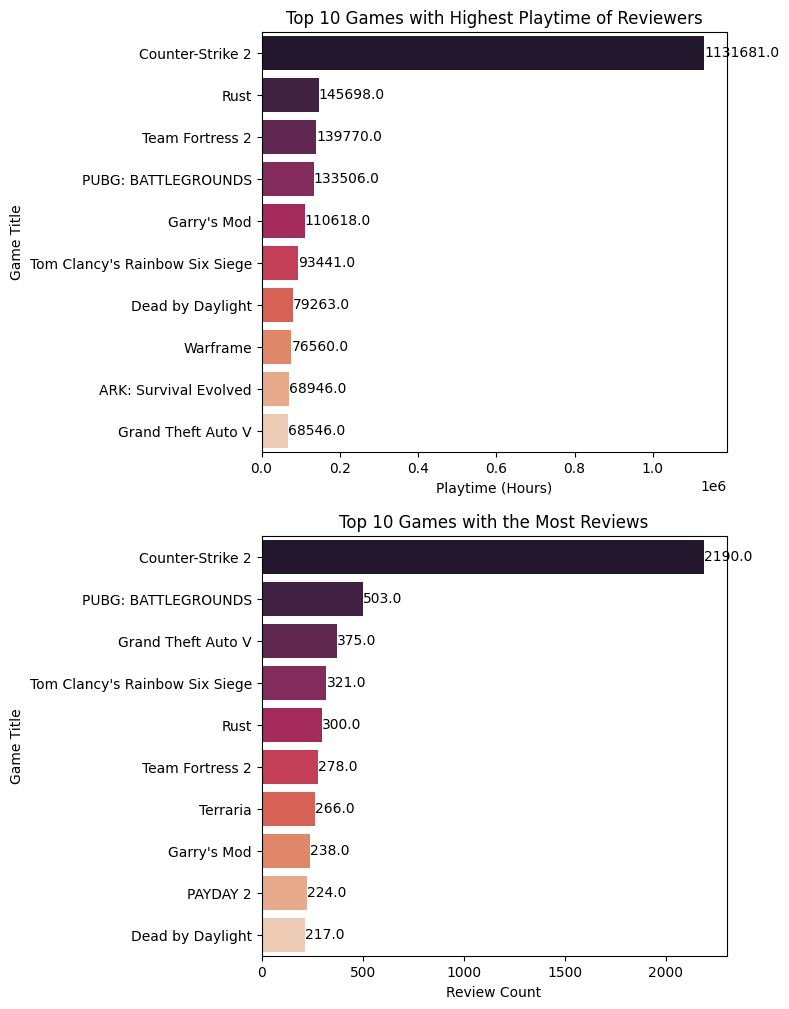

In [ ]:
# # Bargraph of top 10 games with the most total playtime per reviewer, top 10 games with most reviews
# # Omitting stats on average playtime per review as would be skewed towards games with fewer reviews

# fig, axes = plt.subplots(2,1,figsize = (6,12))

# # Plot 1: Top 10 games with the most total playtime per reviewer
# sns.barplot(
#     y = top_10_reviewer_playtimes_df["game"],
#     x = top_10_reviewer_playtimes_df["Total Reviewer Playtime (At time of review)"],
#     ax = axes[0],
#     palette = "rocket",
#     orient = "h"
# )
# axes[0].set_title("Top 10 Games with Highest Playtime of Reviewers")
# axes[0].set_ylabel("Game Title")
# axes[0].set_xlabel("Playtime (Hours)")
# for container in axes[0].containers:
#   axes[0].bar_label(container, fmt='%.1f')

# # Plot 2: Top 10 games with most reviews
# sns.barplot(
#     y = top_10_review_count_df["game"],
#     x = top_10_review_count_df["Review Count"],
#     ax = axes[1],
#     palette = "rocket", 
#     orient = "h"
# )
# axes[1].set_title("Top 10 Games with the Most Reviews")
# axes[1].set_ylabel("Game Title")
# axes[1].set_xlabel("Review Count")
# for container in axes[1].containers:
#   axes[1].bar_label(container, fmt='%.1f')

# plt.show()

## Visualizations - Scatter Plots

In [ ]:
# # Curious to see if there is a pattern regarding playtime and weighted vote score

# playtime_votescore_df = df_cleaned.select("weighted_vote_score", "author_playtime_at_review").toPandas()

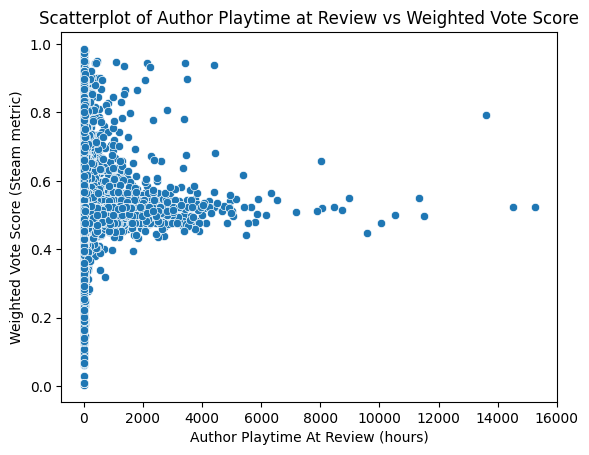

In [ ]:
# sns.scatterplot(
#     data = playtime_votescore_df,
#     y = "weighted_vote_score",
#     x = "author_playtime_at_review"
# )

# plt.title("Scatterplot of Author Playtime at Review vs Weighted Vote Score")
# plt.ylabel("Weighted Vote Score (Steam metric)")
# plt.xlabel("Author Playtime At Review (hours)")

# plt.show()